
# **Create Interactions Data**

In [1]:
import dask.dataframe as dd
import pandas as pd


In [12]:
df_attendees = dd.read_csv("/home/nkama/masters_thesis_project/thesis/data/event_rec_engine_challenge/event_attendees.csv",
                       dtype={
                           'event': 'object'
                       })



## Get User-Event Records


In [13]:
df_attendees.head()

,event,yes,maybe,invited,no
0,1159822043,1975964455 252302513 4226086795 3805886383 142...,2733420590 517546982 1350834692 532087573 5831...,1723091036 3795873583 4109144917 3560622906 31...,3575574655 1077296663
1,686467261,2394228942 2686116898 1056558062 3792942231 41...,1498184352 645689144 3770076778 331335845 4239...,1788073374 733302094 1830571649 676508092 7081...,<NA>
2,1186208412,<NA>,3320380166 3810793697,1379121209 440668682,1728988561 2950720854
3,2621578336,<NA>,<NA>,<NA>,<NA>
4,855842686,2406118796 3550897984 294255260 1125817077 109...,2671721559 1761448345 2356975806 2666669465 10...,1518670705 880919237 2326414227 2673818347 332...,3500235232


In [14]:
df_attendees.isnull().sum().compute()

event         0
yes        1984
maybe      3167
invited    1822
no         6659
dtype: int64

In [15]:

col = ['yes',	'maybe', 'invited',	'no']
df_attendee_new = df_attendees.dropna(subset=col, how='all')

In [16]:
df_attendee_new.head()

,event,yes,maybe,invited,no
0,1159822043,1975964455 252302513 4226086795 3805886383 142...,2733420590 517546982 1350834692 532087573 5831...,1723091036 3795873583 4109144917 3560622906 31...,3575574655 1077296663
1,686467261,2394228942 2686116898 1056558062 3792942231 41...,1498184352 645689144 3770076778 331335845 4239...,1788073374 733302094 1830571649 676508092 7081...,<NA>
2,1186208412,<NA>,3320380166 3810793697,1379121209 440668682,1728988561 2950720854
4,855842686,2406118796 3550897984 294255260 1125817077 109...,2671721559 1761448345 2356975806 2666669465 10...,1518670705 880919237 2326414227 2673818347 332...,3500235232
6,488116622,4145960786 2550625355 2577667841 1575121941 28...,1227223575 2789471603 1323321680 3086272918 38...,1413359297 2300232602 1412759254 617751520 286...,1498160155 3708150269 823488244 3595018395 173...


In [17]:
df = df_attendee_new[(df_attendee_new['yes'].isna() & df_attendee_new['maybe'].isna() & df_attendee_new['no'].isna())]

len(df)

272

In [18]:
# Fill remaining NaN values with 0
df_attendee_new = df_attendee_new.fillna('0')

In [19]:
#df_attendee_new.compute().to_csv("attendee_new.csv",index=False)


## Count total reactions on each event

We check if the input is '0' and return 0 if it is.

We convert the input to a string before splitting, to handle potential numeric inputs.

We filter out '0' values when counting users.

We renamed 'total_reactions' to 'total_users' for clarity.

These modifications ensure that:

A single '0' in a column is counted as 0 users.

'0' values mixed with other user IDs are not counted.


In [20]:
import dask.dataframe as dd
import pandas as pd
import numpy as np

# Function to count users in a space-separated string
def count_users(x):
    if pd.isna(x) or x == '0':
        return 0
    users = str(x).split()
    return len([u for u in users if u != '0'])

# Create new columns for user counts directly in the original dataframe
for column in ['yes', 'maybe', 'invited', 'no']:
    df_attendee_new[f'{column}_count'] = df_attendee_new[column].apply(count_users, meta=('x', 'int'))

# Calculate total attendees (sum of all categories)
df_attendee_new['total_users'] = df_attendee_new['yes_count'] + \
                              df_attendee_new['maybe_count'] + \
                              df_attendee_new['invited_count'] + \
                              df_attendee_new['no_count']

# Select only the event and count columns
attendance_counts = df_attendee_new[['event', 'yes_count', 'maybe_count', 'invited_count', 'no_count', 'total_users']]

attendance_counts = attendance_counts.compute()


In [21]:
attendance_counts.head()

,event,yes_count,maybe_count,invited_count,no_count,total_users
0,1159822043,7,7,70,2,86
1,686467261,11,8,75,0,94
2,1186208412,0,2,2,2,6
4,855842686,6,6,10,1,23
6,488116622,45,38,166,19,268


In [22]:
len(attendance_counts.event) #print number of unique events
#save to csv
#attendance_counts.to_csv("attendance_counts.csv", index=False)

22710

In [31]:
def extract_user_event_pairs(df_attendees):
    def process_row(row):
        event_id = row.event  
        pairs = []
        for status in ['yes', 'maybe', 'invited', 'no']:
            if pd.notna(getattr(row, status)) and getattr(row, status) != '0':
                users = str(getattr(row, status)).split()
                for user_id in users:
                    if user_id != '0':
                        # Check if the user is invited and has responded
                        if status == 'invited' and (row.yes != '0' or row.maybe != '0' or row.no != '0'):
                            attendance_status = 'invited & yes' if row.yes != '0' else ('invited & maybe' if row.maybe != '0' else 'invited & no')
                        else:
                            attendance_status = status
                        pairs.append({'event_id': event_id, 'user_id': user_id, 'interaction_type': attendance_status})
        return pairs

    # Apply the function to each partition
    pairs_ddf = df_attendees.map_partitions(
        lambda df: pd.DataFrame(
            [pair for row in df.itertuples() for pair in process_row(row)]
        )
    )

    return pairs_ddf

In [32]:

# Extracting user-event pairs
user_event_pairs = extract_user_event_pairs(df_attendee_new)


In [33]:
user_event_pairs = user_event_pairs.compute()

In [34]:
# Convert types to ensure consistency for joining or merging
user_event_pairs['user_id'] = user_event_pairs['user_id'].astype(str)
user_event_pairs['event_id'] = user_event_pairs['event_id'].astype(str)


In [43]:
user_event_pairs.head()

,event_id,user_id,interaction_type
0,1159822043,1975964455,yes
1,1159822043,252302513,yes
2,1159822043,4226086795,yes
3,1159822043,3805886383,yes
4,1159822043,1420484491,yes


In [42]:
user_event_pairs[user_event_pairs["interaction_type"]=="invited & yes"].head()

,event_id,user_id,interaction_type
14,1159822043,1723091036,invited & yes
15,1159822043,3795873583,invited & yes
16,1159822043,4109144917,invited & yes
17,1159822043,3560622906,invited & yes
18,1159822043,3106484834,invited & yes


In [38]:
len(user_event_pairs[user_event_pairs["interaction_type"]=="invited & yes"])

9398000

In [39]:
len(user_event_pairs[user_event_pairs["interaction_type"]=="invited & no"])

5587

In [40]:
len(user_event_pairs[user_event_pairs["interaction_type"]=="invited & maybe"])

9402

In [44]:
len(user_event_pairs)

11245010

In [55]:
user_event_pairs['interaction_label'] = user_event_pairs['interaction_type'].apply(
    lambda x: 1 if x in ['yes', 'maybe','invited & yes','invited & maybe'] 
    else (0 if pd.notna(x) else 0)
)


In [50]:
user_event_pairs.head()

,event_id,user_id,interaction_type,interaction_label
0,1159822043,1975964455,yes,1
1,1159822043,252302513,yes,1
2,1159822043,4226086795,yes,1
3,1159822043,3805886383,yes,1
4,1159822043,1420484491,yes,1


In [56]:
user_event_pairs[user_event_pairs["interaction_type"]=='invited & no']

,event_id,user_id,interaction_type,interaction_label
113411,2730531110,587226496,invited & no,0
113412,2730531110,2938205322,invited & no,0
113413,2730531110,1772527144,invited & no,0
131855,2706957558,905238652,invited & no,0
131856,2706957558,1793154035,invited & no,0
...,...,...,...,...
11167828,1807765078,277039486,invited & no,0
11167829,1807765078,2972745086,invited & no,0
11167830,1807765078,766348384,invited & no,0
11167831,1807765078,134853927,invited & no,0


In [57]:
user_event_pairs.isnull().sum()

event_id             0
user_id              0
interaction_type     0
interaction_label    0
dtype: int64

In [58]:
len(user_event_pairs)

11245010

In [59]:
len(user_event_pairs.event_id.unique()), len(user_event_pairs.user_id.unique())

(22710, 3702045)

In [ ]:
user_event_pairs.interaction_type.value_counts()


interaction_type
invited & yes      9398000
yes                 831137
maybe               520724
no                  474438
invited & maybe       9402
invited               5722
invited & no          5587
Name: count, dtype: int64

In [61]:
#save as interactions data
user_event_pairs.to_csv("interactions_data.csv")


## Ensure interactions_df, events_df and users_df all have the needed features for the model evaluation

In [12]:
import pandas as pd
interactions_df =pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/interactions_data.csv")

users_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/users_data.csv")
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/complete_events_data.csv")


In [13]:
print(len(users_df))
users_df.head()

9524


,Unnamed: 0,user_id,gender,joinedAt,location,age,lat,lng
0,0,3197468391,male,2012-10-02T06:40:55.524Z,Medan Indonesia,19,3.590,98.674
1,1,3537982273,male,2012-09-29T18:03:12.111Z,Medan Indonesia,20,3.590,98.674
2,2,3473687777,female,2012-10-03T12:19:29.975Z,Medan Indonesia,47,3.590,98.674
3,4,2411726276,female,2012-10-30T05:16:27.136Z,Triolet Mauritius,16,-20.057,57.552
4,5,1091720544,female,2012-10-30T11:55:19.469Z,Plaine Des Papayes Pamplemousses Mauritius,24,-20.063,57.581


In [14]:
print(len(events_df))
events_df.head(2)

11627


,Unnamed: 0,event_id,start_time,city,lat,lng,yes_count,maybe_count,invited_count,no_count,total_users,weather_description,category,title,event_type
0,0,2587616435,2012-11-13T11:00:00.002Z,Sihanoukville,10.633,103.500,93,65,317,47,522,Light Drizzle,Education & Learning,Sihanoukville Knowledge Festival 2025 - Mornin...,Indoor
1,1,1145166049,2013-07-08T02:00:00.000Z,Palo Alto,37.442,-122.172,162,112,1021,150,1445,Cloudy,Business & Networking,Palo Alto Summer Night Networking Bash,Indoor


In [15]:
print(len(interactions_df))
interactions_df.head()

11245010


,Unnamed: 0,event_id,user_id,interaction_type,interaction_label
0,0,1159822043,1975964455,yes,1
1,1,1159822043,252302513,yes,1
2,2,1159822043,4226086795,yes,1
3,3,1159822043,3805886383,yes,1
4,4,1159822043,1420484491,yes,1


### Calculate event indoo/outdoor capability to match synthetic data features


In [16]:
events_df["event_indoor_capability"] = events_df["event_type"].map({'Indoor': True, 'Outdoor': False})

### Add weather features, temperature and precipitation to events_df


In [17]:
col = ['event_id', 'temperature_2m_mean', 'precipitation_sum']
event_weather_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/event_data_category_gen.csv")[col]
events_df = events_df.merge(event_weather_df,on="event_id")
print(len(events_df))

11627


In [18]:
events_df.head(1)

,Unnamed: 0,event_id,start_time,city,lat,lng,yes_count,maybe_count,invited_count,no_count,total_users,weather_description,category,title,event_type,event_indoor_capability,temperature_2m_mean,precipitation_sum
0,0,2587616435,2012-11-13T11:00:00.002Z,Sihanoukville,10.633,103.5,93,65,317,47,522,Light Drizzle,Education & Learning,Sihanoukville Knowledge Festival 2025 - Mornin...,Indoor,True,28.318502,0.1


## Merge all dataframes

In [19]:
merged_df = interactions_df.merge(users_df,on="user_id").merge(events_df,on="event_id")
merged_df.head(2)


,Unnamed: 0_x,event_id,user_id,interaction_type,interaction_label,Unnamed: 0_y,gender,joinedAt,location,age,...,invited_count,no_count,total_users,weather_description,category,title,event_type,event_indoor_capability,temperature_2m_mean,precipitation_sum
0,2561,702719295,3468617687,maybe,1,749,female,2012-09-25T17:48:37.804Z,Saint Catharines Ontario,20,...,93,22,264,Cloudy,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,3.7455,0.0
1,2562,702719295,487910947,maybe,1,1748,male,2012-09-25T16:28:31.617Z,Toronto Ontario,22,...,93,22,264,Cloudy,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,3.7455,0.0


In [20]:
len(merged_df)

28249

In [21]:
unique_users = merged_df["user_id"].unique().tolist()
print(len(unique_users))

5315


In [22]:
unique_events = merged_df["event_id"].unique()
print(len(unique_events))

4967


### Create user indoor_outdoor_preference feature

In [23]:
import pandas as pd

# Define a function to determine user weather preference
def determine_weather_preference(group):
    event_types = group['event_type'].unique()
    if 'Indoor' in event_types and 'Outdoor' in event_types:
        return 'any'
    elif 'Indoor' in event_types:
        return 'indoor'
    elif 'Outdoor' in event_types:
        return 'outdoor'
    else:
        return 'any'  # Default case if no events are found
df = merged_df.copy()
# Group by user_id and apply the function
user_preferences = df.groupby('user_id').apply(determine_weather_preference).reset_index()

# Rename the columns for clarity
user_preferences.columns = ['user_id', 'indoor_outdoor_preference']

# Merge the preferences back into the original DataFrame
merged_df = df.merge(user_preferences, on='user_id', how='left')

# Display the updated DataFrame
merged_df.drop_duplicates().head()

,Unnamed: 0_x,event_id,user_id,interaction_type,interaction_label,Unnamed: 0_y,gender,joinedAt,location,age,...,no_count,total_users,weather_description,category,title,event_type,event_indoor_capability,temperature_2m_mean,precipitation_sum,indoor_outdoor_preference
0,2561,702719295,3468617687,maybe,1,749,female,2012-09-25T17:48:37.804Z,Saint Catharines Ontario,20,...,22,264,Cloudy,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,3.745500,0.0,indoor
1,2562,702719295,487910947,maybe,1,1748,male,2012-09-25T16:28:31.617Z,Toronto Ontario,22,...,22,264,Cloudy,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,3.745500,0.0,any
2,2607,702719295,2769572227,invited & yes,1,2150,female,2012-09-25T15:40:36.962Z,Toronto Ontario,24,...,22,264,Cloudy,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,3.745500,0.0,any
3,2629,702719295,2974942354,invited & yes,1,1839,male,2012-10-11T18:00:17.768Z,Toronto Ontario,22,...,22,264,Cloudy,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,3.745500,0.0,any
4,1380515,284003894,3468617687,invited & yes,1,749,female,2012-09-25T17:48:37.804Z,Saint Catharines Ontario,20,...,207,3085,Cloudy,Entertainment,Fall Night Lights Toronto - A Celebration of S...,Indoor,True,11.129666,0.0,indoor


In [24]:
len(merged_df)

28249

### Create user interests feature

In [25]:
# Define a list of interests
interests = [
    'Music', 'Concerts',
    'Food', 'Drink',   
    'Education', 'Learning',
    'Sports', 'Fitness',  
    'Arts', 'Culture', 
    'Business', 'Networking',
    'Technology',           
    'Community', 'Causes', 
    'Health', 'Wellness',   
    'Entertainment',       
    'Seasonal', 'Festivals',
    'Immersive', 'Experiences' 
]

def get_user_interests(interactions_df):
    """
    Get unique event categories for each user and determine their interests.
    
    Parameters:
    - interactions_df: DataFrame containing user-event interactions with category information
    
    Returns:
    - DataFrame with original data plus user_interests column as a string
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = interactions_df.copy()
    
    # Step 1: Group by user_id and collect unique interests
    user_categories_dict = {}
    
    # Group by user_id and get unique categories
    for user_id, group in df.groupby('user_id'):
        user_categories_dict[user_id] = set()  # Use a set to avoid duplicates
        
        # Check each row in the group for interests
        for _, row in group.iterrows():
            category = row.get('category', '')
            # Split the category string to check for multiple interests
            category_list = [cat.strip() for cat in category.split('&')]
            for cat in category_list:
                # Check if the category matches any interest
                for interest in interests:
                    if interest in cat:
                        user_categories_dict[user_id].add(interest)

    # Step 2: Add user_interests to the original dataframe
    df['user_interests'] = df['user_id'].map(lambda user_id: ', '.join(user_categories_dict.get(user_id, [])))
    
    return df

# Process the sample data
merged_df = get_user_interests(merged_df)    

### calculate users location distance to events 


In [26]:
from geopy.distance import geodesic

merged_df["distance_to_event"] = merged_df.apply(lambda row: geodesic((row['lat_x'], row['lng_x']), 
                    (row['lat_y'], row['lng_y'])).km, axis=1)



In [27]:
merged_df.head(2)

,Unnamed: 0_x,event_id,user_id,interaction_type,interaction_label,Unnamed: 0_y,gender,joinedAt,location,age,...,weather_description,category,title,event_type,event_indoor_capability,temperature_2m_mean,precipitation_sum,indoor_outdoor_preference,user_interests,distance_to_event
0,2561,702719295,3468617687,maybe,1,749,female,2012-09-25T17:48:37.804Z,Saint Catharines Ontario,20,...,Cloudy,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,3.7455,0.0,indoor,"Technology, Business, Food, Entertainment, Dri...",522.753486
1,2562,702719295,487910947,maybe,1,1748,male,2012-09-25T16:28:31.617Z,Toronto Ontario,22,...,Cloudy,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,3.7455,0.0,any,"Technology, Music, Business, Food, Entertainme...",506.036813


### Get user weather information during event time.


In [28]:
side_merged_df = merged_df[['temperature_2m_mean', 'precipitation_sum']]
len(side_merged_df)

28249

In [ ]:
# importing the script with functions to split dataframe, retreive weather info and concat all splits  
from thesis.partially_synthetic.src.weather_data import get_weather_info
merged_df = get_weather_info(merged_df, lat_col='lat_x', lon_col='lng_x', id_col='user_id')

#### load the already retrieved user weather data instead of running the function call above again

In [29]:
merged_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/user_weather_data").\
drop(columns=(["Unnamed: 0.1","Unnamed: 0_x", "Unnamed: 0_y"]))



### Get weather codes for user weather info


In [30]:
import pandas as pd
import json

# Load the weather descriptions from JSON file
with open('/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/descriptions.json', 'r') as f:
    weather_descriptions = json.load(f)

# Create a mapping dictionary for weather codes to descriptions
weather_code_mapping = {float(key): value["day"]["description"] for key, value in weather_descriptions.items()}

# Replace weather codes with descriptions in the DataFrame
merged_df['user_weather_condition'] = merged_df['weather_code'].map(weather_code_mapping)
merged_df = merged_df.drop(columns=(["weather_code","precipitation_hours", "wind_speed_10m_max"]))

# Example: Display the updated DataFrame
merged_df.head()


,event_id,user_id,interaction_type,interaction_label,gender,joinedAt,location,age,lat_x,lng_x,...,category,title,event_type,event_indoor_capability,temperature_2m_mean,precipitation_sum,indoor_outdoor_preference,user_interests,distance_to_event,user_weather_condition
0,702719295,3468617687,maybe,1,female,2012-09-25T17:48:37.804Z,Saint Catharines Ontario,20,43.158,-79.244,...,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,5.463667,0.0,indoor,"Drink, Technology, Business, Seasonal, Food, E...",522.753486,Cloudy
1,702719295,487910947,maybe,1,male,2012-09-25T16:28:31.617Z,Toronto Ontario,22,43.653,-79.384,...,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,4.505249,0.1,any,"Drink, Technology, Music, Education, Learning,...",506.036813,Light Drizzle
2,702719295,2769572227,invited & yes,1,female,2012-09-25T15:40:36.962Z,Toronto Ontario,24,43.653,-79.384,...,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,4.505249,0.1,any,"Drink, Music, Education, Fitness, Experiences,...",506.036813,Light Drizzle
3,702719295,2974942354,invited & yes,1,male,2012-10-11T18:00:17.768Z,Toronto Ontario,22,43.653,-79.384,...,Food & Drink,Montreal Spring Bites Night Market | Food Truc...,Indoor,True,4.505249,0.1,any,"Drink, Technology, Music, Education, Learning,...",506.036813,Light Drizzle
4,284003894,3468617687,invited & yes,1,female,2012-09-25T17:48:37.804Z,Saint Catharines Ontario,20,43.158,-79.244,...,Entertainment,Fall Night Lights Toronto - A Celebration of S...,Indoor,True,11.065750,0.0,indoor,"Drink, Technology, Business, Seasonal, Food, E...",55.942166,Partly Cloudy


In [31]:
side_merged_df.columns = ['event_temperature', 'event_precipitation_sum']
len(side_merged_df)

28249

In [32]:
merged_df = pd.concat([merged_df, side_merged_df], axis=1)
print(len(merged_df))


28249


In [33]:
merged_df.head(2)

,event_id,user_id,interaction_type,interaction_label,gender,joinedAt,location,age,lat_x,lng_x,...,event_type,event_indoor_capability,temperature_2m_mean,precipitation_sum,indoor_outdoor_preference,user_interests,distance_to_event,user_weather_condition,event_temperature,event_precipitation_sum
0,702719295,3468617687,maybe,1,female,2012-09-25T17:48:37.804Z,Saint Catharines Ontario,20,43.158,-79.244,...,Indoor,True,5.463667,0.0,indoor,"Drink, Technology, Business, Seasonal, Food, E...",522.753486,Cloudy,3.7455,0.0
1,702719295,487910947,maybe,1,male,2012-09-25T16:28:31.617Z,Toronto Ontario,22,43.653,-79.384,...,Indoor,True,4.505249,0.1,any,"Drink, Technology, Music, Education, Learning,...",506.036813,Light Drizzle,3.7455,0.0


In [36]:
print(len(merged_df))
merged_df.columns

28249


Index(['event_id', 'user_id', 'interaction_type', 'interaction_label',
       'gender', 'joinedAt', 'location', 'age', 'lat_x', 'lng_x', 'Unnamed: 0',
       'start_time', 'city', 'lat_y', 'lng_y', 'yes_count', 'maybe_count',
       'invited_count', 'no_count', 'total_users', 'weather_description',
       'category', 'title', 'event_type', 'event_indoor_capability',
       'temperature_2m_mean', 'precipitation_sum', 'indoor_outdoor_preference',
       'user_interests', 'distance_to_event', 'user_weather_condition',
       'event_temperature', 'event_precipitation_sum'],
      dtype='object')

### Create main users data

In [38]:
users_df_new = users_df[users_df["user_id"].isin(unique_users)]
len(users_df_new)

5315

In [39]:
main_users_df = users_df_new.merge(merged_df[['user_id','indoor_outdoor_preference', 'user_interests']], 
                                 on="user_id")

main_users_df = main_users_df[main_users_df["user_id"].isin(unique_users)].drop("Unnamed: 0",axis=1)
print(len(main_users_df))
main_users_df.head(2)

28249


,user_id,gender,joinedAt,location,age,lat,lng,indoor_outdoor_preference,user_interests
0,3197468391,male,2012-10-02T06:40:55.524Z,Medan Indonesia,19,3.59,98.674,indoor,"Technology, Business, Seasonal, Entertainment,..."
1,3197468391,male,2012-10-02T06:40:55.524Z,Medan Indonesia,19,3.59,98.674,indoor,"Technology, Business, Seasonal, Entertainment,..."


In [40]:
main_users_df.drop_duplicates(inplace=True)
print(len(main_users_df))
main_users_df.head(2)

5315


,user_id,gender,joinedAt,location,age,lat,lng,indoor_outdoor_preference,user_interests
0,3197468391,male,2012-10-02T06:40:55.524Z,Medan Indonesia,19,3.590,98.674,indoor,"Technology, Business, Seasonal, Entertainment,..."
14,1091720544,female,2012-10-30T11:55:19.469Z,Plaine Des Papayes Pamplemousses Mauritius,24,-20.063,57.581,indoor,"Technology, Seasonal, Festivals"


### Create main events data

In [41]:
main_events_df = events_df[events_df["event_id"].isin(unique_events)].drop("Unnamed: 0",axis=1)
print(len(main_events_df))
main_events_df.head(2)

4967


,event_id,start_time,city,lat,lng,yes_count,maybe_count,invited_count,no_count,total_users,weather_description,category,title,event_type,event_indoor_capability,temperature_2m_mean,precipitation_sum
0,2587616435,2012-11-13T11:00:00.002Z,Sihanoukville,10.633,103.500,93,65,317,47,522,Light Drizzle,Education & Learning,Sihanoukville Knowledge Festival 2025 - Mornin...,Indoor,True,28.318502,0.1
1,1145166049,2013-07-08T02:00:00.000Z,Palo Alto,37.442,-122.172,162,112,1021,150,1445,Cloudy,Business & Networking,Palo Alto Summer Night Networking Bash,Indoor,True,18.417002,0.0


In [44]:
merged_df.columns = ['event_id', 'user_id', 'interaction_type', 'interaction_label',
       'gender', 'joinedAt', 'location', 'age', 'user_lat', 'user_lng', 'Unnamed: 0',
       'start_time', 'city', 'event_lat', 'event_lng', 'yes_count', 'maybe_count',
       'invited_count', 'no_count', 'total_users', 'event_weather_condition',
       'category', 'title', 'event_type', 'event_indoor_capability',
       'user_temperature', 'user_precipitation', 'indoor_outdoor_preference',
       'user_interests', 'distance_to_event', 'user_weather_condition',
       'event_temperature', 'event_precipitation_sum'] 

### Create main interactions data

In [47]:
interactions_col =['event_id', 'user_id', 'interaction_type','distance_to_event','interaction_label',
                   'event_weather_condition','user_temperature', 'user_precipitation',
                   'user_weather_condition','event_temperature', 'event_precipitation_sum'
                ]
main_interactions_df = merged_df[interactions_col]
main_interactions_df.head(2)

,event_id,user_id,interaction_type,distance_to_event,interaction_label,event_weather_condition,user_temperature,user_precipitation,user_weather_condition,event_temperature,event_precipitation_sum
0,702719295,3468617687,maybe,522.753486,1,Cloudy,5.463667,0.0,Cloudy,3.7455,0.0
1,702719295,487910947,maybe,506.036813,1,Cloudy,4.505249,0.1,Light Drizzle,3.7455,0.0


In [48]:
len(main_interactions_df)

28249

In [49]:
print(merged_df["event_weather_condition"].unique())
merged_df["user_weather_condition"].unique()


['Cloudy' 'Light Rain' 'Snow' 'Rain' 'Heavy Drizzle' 'Drizzle'
 'Light Snow' 'Light Drizzle' 'Partly Cloudy' 'Mainly Sunny' 'Heavy Rain'
 'Sunny' 'Heavy Snow']


array(['Cloudy', 'Light Drizzle', 'Partly Cloudy', 'Light Rain',
       'Drizzle', 'Rain', 'Snow', 'Light Snow', 'Heavy Drizzle',
       'Heavy Rain', 'Sunny', 'Mainly Sunny', 'Heavy Snow'], dtype=object)

In [39]:
weather_map = {
    'Sunny': 'Clear',
    'Mainly Sunny': 'Clear',
    'Partly Cloudy': 'Cloudy',
    'Cloudy': 'Cloudy',

    'Drizzle': 'Rain',
    'Light Drizzle': 'Rain',
    'Heavy Drizzle': 'Rain',

    'Rain': 'Rain',
    'Light Rain': 'Rain',
    'Heavy Rain': 'Rain',

    'Snow': 'Snow',
    'Light Snow': 'Snow',
    'Heavy Snow': 'Snow',
}

merged_df['user_weather_group'] = merged_df['user_weather_condition'].map(weather_map)
merged_df['event_weather_group'] = merged_df['event_weather_condition'].map(weather_map)

merged_df['weather_match'] = (merged_df['user_weather_group'] == merged_df['event_weather_group']).astype(int)
merged_df.head()


,event_id,user_id,interaction_type,interaction_label,gender,joinedAt,location,age,user_lat,user_lng,...,user_precipitation,indoor_outdoor_preference,user_interests,distance_to_event,user_weather_condition,event_temperature,event_precipitation_sum,user_weather_group,event_weather_group,weather_match
0,702719295,3468617687,maybe,1,female,2012-09-25T17:48:37.804Z,Saint Catharines Ontario,20,43.158,-79.244,...,0.0,indoor,"Drink, Technology, Business, Seasonal, Food, E...",522.753486,Cloudy,3.745500,0.0,Cloudy,Cloudy,1
1,702719295,487910947,maybe,1,male,2012-09-25T16:28:31.617Z,Toronto Ontario,22,43.653,-79.384,...,0.1,any,"Drink, Technology, Music, Education, Learning,...",506.036813,Light Drizzle,3.745500,0.0,Rain,Cloudy,0
2,702719295,2769572227,invited & yes,1,female,2012-09-25T15:40:36.962Z,Toronto Ontario,24,43.653,-79.384,...,0.1,any,"Drink, Music, Education, Fitness, Experiences,...",506.036813,Light Drizzle,3.745500,0.0,Rain,Cloudy,0
3,702719295,2974942354,invited & yes,1,male,2012-10-11T18:00:17.768Z,Toronto Ontario,22,43.653,-79.384,...,0.1,any,"Drink, Technology, Music, Education, Learning,...",506.036813,Light Drizzle,3.745500,0.0,Rain,Cloudy,0
4,284003894,3468617687,invited & yes,1,female,2012-09-25T17:48:37.804Z,Saint Catharines Ontario,20,43.158,-79.244,...,0.0,indoor,"Drink, Technology, Business, Seasonal, Food, E...",55.942166,Partly Cloudy,11.129666,0.0,Cloudy,Cloudy,1


In [48]:
import matplotlib.pyplot as plt

weather_match  interaction_type
1              invited & yes       20363
               yes                  2473
0              invited & yes        2146
1              no                   1390
               maybe                1292
0              yes                   243
               no                    188
               maybe                 134
1              invited                10
               invited & maybe         8
               invited & no            2
Name: count, dtype: int64


<Axes: xlabel='weather_match,interaction_type'>

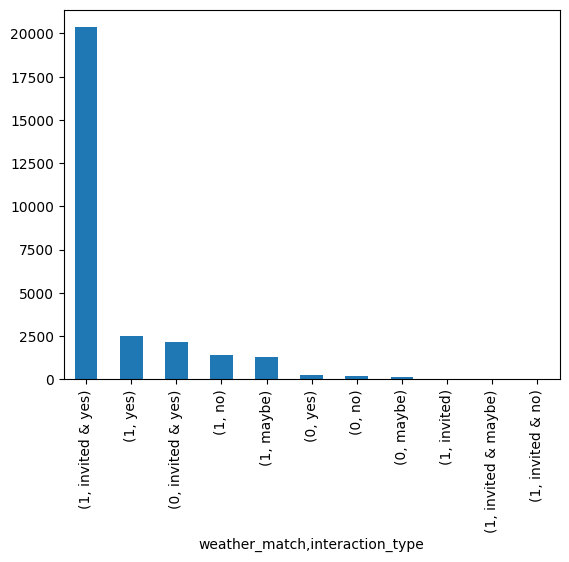

In [56]:
attendance_by_weather_match = merged_df.groupby('weather_match')['interaction_type'].value_counts().sort_values(ascending=False)
print(attendance_by_weather_match)
attendance_by_weather_match.plot(kind="bar")

In [8]:
# Group and count
attendance_summary = merged_df.groupby(['weather_match', 'event_indoor_capability', 'interaction_label']).size().reset_index(name='count')

# Pivot to get attendance rate
pivot_df = attendance_summary.pivot_table(index=['weather_match', 'event_indoor_capability'],
                                          columns='interaction_label',
                                          values='count',
                                          fill_value=0).reset_index()

# Calculate attendance rate
pivot_df['attendance_rate'] = pivot_df[True] / (pivot_df[True] + pivot_df[False])


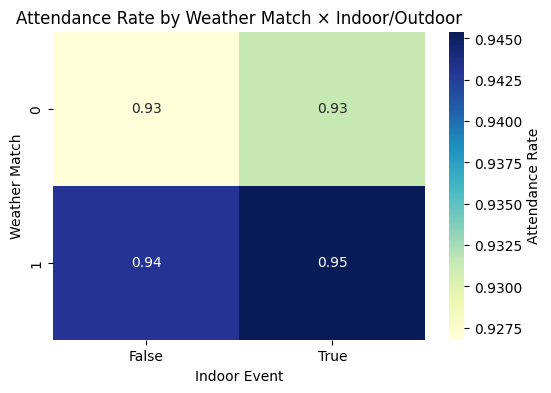

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for heatmap
heatmap_data = pivot_df.pivot(index='weather_match', columns='event_indoor_capability', values='attendance_rate')

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Attendance Rate'})
plt.title("Attendance Rate by Weather Match × Indoor/Outdoor")
plt.ylabel("Weather Match")
plt.xlabel("Indoor Event")
plt.show()


/tmp/ipykernel_797033/1480081573.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Weather Match")


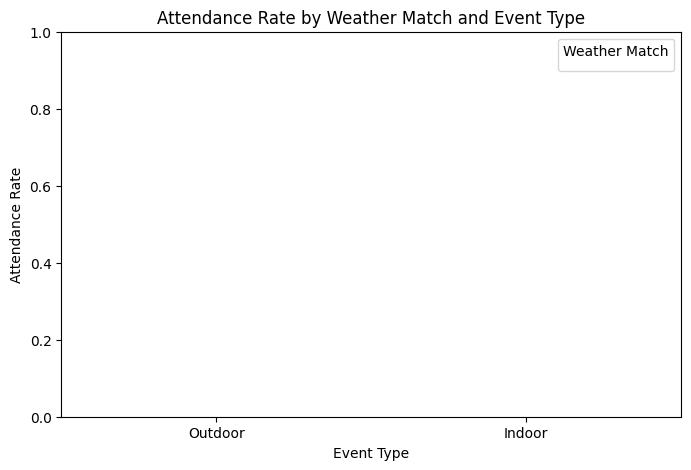

In [11]:
import seaborn as sns

# Create readable labels
pivot_df['weather_match_str'] = pivot_df['weather_match'].map({True: 'Match', False: 'Mismatch'})
pivot_df['category'] = pivot_df['event_indoor_capability'].map({True: 'Indoor', False: 'Outdoor'})

# Plot grouped bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=pivot_df, x='event_type', y='attendance_rate', hue='weather_match_str')
plt.title("Attendance Rate by Weather Match and Event Type")
plt.ylabel("Attendance Rate")
plt.xlabel("Event Type")
plt.ylim(0, 1)
plt.legend(title="Weather Match")
plt.show()


In [66]:
#merged_df.drop(columns=(["Unnamed: 0", "attended"]),inplace=True)
main_interactions_df = pd.concat([main_interactions_df, merged_df[["weather_match"]]])

### Clean event title and user interests feartures

In [59]:
import re
def clean_text(text):
    if not isinstance(text, str):
        return "unknown"
    text = text.lower().strip()
    text = text.replace(',', ' ')
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)     # collapse multiple spaces
    return text if text else "unknown"

def clean_text_columns(df):
    if 'title' in df.columns:
        df["title"] = df["title"].apply(lambda x: clean_text(x) if isinstance(x, str) and x.strip() else "unknown")
    if 'user_interests' in df.columns:
        df["user_interests"] = df["user_interests"].apply(
            lambda x: clean_text(x) if isinstance(x, str) and x.strip() else "unknown")
        
    return df

In [51]:
# main_events_df = clean_text_columns(main_events_df)
# main_users_df = clean_text_columns(main_users_df)
# main_events_df.to_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/events.csv")
# main_users_df.to_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/users.csv")
main_interactions_df.to_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/interactions.csv")
# merged_df.to_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/merged_data.csv")

In [52]:
import pandas as pd
main_events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/events.csv")
main_users_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/users.csv")
main_interactions_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/interactions.csv")
merged_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/merged_data.csv")


In [11]:
main_interactions_df.columns

Index(['Unnamed: 0', 'event_id', 'user_id', 'interaction_type',
       'distance_to_event', 'interaction_label', 'weather_match'],
      dtype='object')

In [55]:
main_events_df["attendance_rate"] = main_events_df["yes_count"] / main_events_df["total_users"]

In [53]:
print(f'events_data: {main_events_df.columns}')
print(f'users_data: {main_users_df.columns}')
print(f'interactions_data: {main_interactions_df.columns}')



events_data: Index(['Unnamed: 0', 'event_id', 'start_time', 'city', 'lat', 'lng',
       'yes_count', 'maybe_count', 'invited_count', 'no_count', 'total_users',
       'weather_description', 'category', 'title', 'event_type',
       'event_indoor_capability', 'temperature_2m_mean', 'precipitation_sum'],
      dtype='object')
users_data: Index(['Unnamed: 0', 'user_id', 'gender', 'joinedAt', 'location', 'age', 'lat',
       'lng', 'indoor_outdoor_preference', 'user_interests'],
      dtype='object')
interactions_data: Index(['Unnamed: 0', 'event_id', 'user_id', 'interaction_type',
       'distance_to_event', 'interaction_label', 'event_weather_condition',
       'user_temperature', 'user_precipitation', 'user_weather_condition',
       'event_temperature', 'event_precipitation_sum'],
      dtype='object')


In [56]:
users_new_col = ['user_id', 'lat', 'lng', 'location',
       'indoor_outdoor_preference', 'age', 'user_interests', 'joinedAt']
main_users_df = main_users_df[users_new_col]

main_events_df = main_events_df[['event_id', 'title', 'category', 'lat', 'lng',
       'city', 'start_time', 'weather_description',
       'temperature_2m_mean', 'attendance_rate', 'event_indoor_capability','precipitation_sum']]
main_interactions_df = main_interactions_df[['user_id', 'event_id', 'interaction_type',
       'distance_to_event','interaction_label','event_weather_condition','event_temperature', 
       'event_precipitation_sum', 'user_weather_condition','user_temperature', 
       'user_precipitation']]

In [57]:
main_interactions_df.to_csv("test_interactions_data.csv")
main_events_df.to_csv("test_events_data.csv")
main_users_df.to_csv("test_users_data.csv")

In [ ]:
main_interactions_df["user_id"].isnull().sum()

Index(['user_id', 'user_lat', 'user_lon', 'user_city',
       'user_weather_preference', 'age', 'user_interests', 'signup_date',
       'social_connectedness'],
      dtype='object')
Index(['event_id', 'title', 'event_type', 'event_lat', 'event_lon',
       'event_city', 'start_time', 'duration', 'weather_condition',
       'temperature', 'attendance_rate', 'event_indoor_capability'],
      dtype='object')
Index(['interaction_id', 'user_id', 'event_id', 'interaction_type',
       'interaction_time', 'interaction_distance_to_event'],
      dtype='object')